<a id=0></a>    
<div style="padding:15px;
            color:white;
            margin:0;
            font-size:200%;
            text-align:center;
            display:fill;
            border-radius:5px;
            background-color:#0f4c5c;
            overflow:hidden;
            font-weight:500">
    <b>
        Rice Classification
</b></div>

## <b>Table of contents:

1. [Executive Summary](#1)
2. [Imports](#2)
3. [Brief EDA](#3)
4. [ Dimensionality Reduction with PCA](#4)
5. [Evaluate models on 20 PCA components](#5)
6. [Evaluate models on 300 PCA components](#6)
7. [Classical Computer Vision](#7)
8. [Transfer Learning - Mobile Net](#8)


<a id=1></a>    
<div style="padding:15px;
            color:white;
            margin:0;
            font-size:200%;
            text-align:center;
            display:fill;
            border-radius:5px;
            background-color:#588157;
            overflow:hidden;
            font-weight:500">
        1. Executive Summary
</div>

[go on top](#0)
<br>[go next chapter ↓](#2)

Rice, which is among the most widely produced grain products worldwide, has many genetic varieties. These varieties are separated from each other due to some of their features. These are usually features such as texture, shape, and color. With these features that distinguish rice varieties, it is possible to classify and evaluate the quality of seeds. In this study, Arborio, Basmati, Ipsala, Jasmine and Karacadag, which are five different varieties of rice often grown in Turkey, were used. A total of 75,000 grain images, 15,000 from each of these varieties, are included in the dataset.

I have tested 2 approaches:
- Dimensionality reduction with PCA - from 250x250 pixels to 20 components. Then I have applied clasification algorithms (Decision Trees, Logistic Regression, Gradient Boosting etc);
- Classical computer vision (1 vanilla convnet and Mobile net with transfer learning).

Results are as follows:
- XGBClassifier reached an accuracy of 0.978 based on 20 features created with PCA. Inference time was only 0.01 seconds for 12500 examples. Similar results achieved LGBMClassifier and SVM;
- Classical convolutional networks took more than 30 seconds for inference and achieved accuracies of 0.91;
- Other algorithms such as Logistic regression, Decision Tree, Random Forest showed less acurate results.

I suggest using XGBClassifier given the high accuracy and low computational need. It It is most suited for edge devices in industrial applications.

Means for further improvement:
- Training algorithms on more PCA components (compared to 20 in this notebook);
- Using ensembles;
- Hyperparameter tunning.

<a id=2></a>
<div style="padding:15px;
            color:white;
            margin:0;
            font-size:200%;
            text-align:center;
            display:fill;
            border-radius:5px;
            background-color:#706677;
            overflow:hidden;
            font-weight:500">
        2. Imports
</div>

[go on top](#0)
<br>[go previous chapter ↑](#1)
<br>[go next chapter ↓](#3)

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers

# Models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.multiclass import OneVsOneClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier

# Utilities
from time import time
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import pathlib
from sklearn.preprocessing import LabelEncoder 
from sklearn.metrics import accuracy_score
from keras.utils import image_dataset_from_directory as idfd
from PIL import Image

# ignore warnings 
from warnings import simplefilter
simplefilter("ignore")

# For multiple pretty-prints of dataframes from single cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

<a id=3></a>    
<div style="padding:15px;
            color:white;
            margin:0;
            font-size:200%;
            text-align:center;
            display:fill;
            border-radius:5px;
            background-color:#489fb5;
            overflow:hidden;
            font-weight:500">
       3. Brief EDA 
</div>

[go on top](#0)
<br>[go previous chapter ↑](#2)
<br>[go next chapter ↓](#4)

In [2]:
categories = ["Arborio", "Basmati", "Ipsala", "Jasmine", "Karacadag"]

original_dir = pathlib.Path("./data/original")
new_base_dir = pathlib.Path("./data/splited")

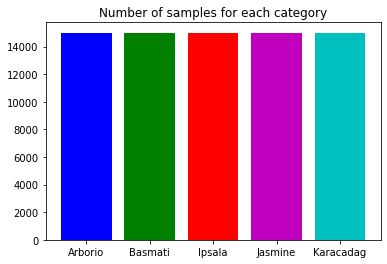

In [3]:
# Plot number of samples for each category
n_of_elements = []
for category in categories:
    i = 0 
    for _ in (original_dir/category).iterdir():
        i += 1
    n_of_elements.append(i)
plt.rcParams["figure.figsize"] = (7,4)
plt.bar(categories, n_of_elements, color=["b", "g", "r", "m", "c"])
plt.title("Number of samples for each category")
plt.show()

All classes are balanced


Showing 10 examples of Arborio rice:


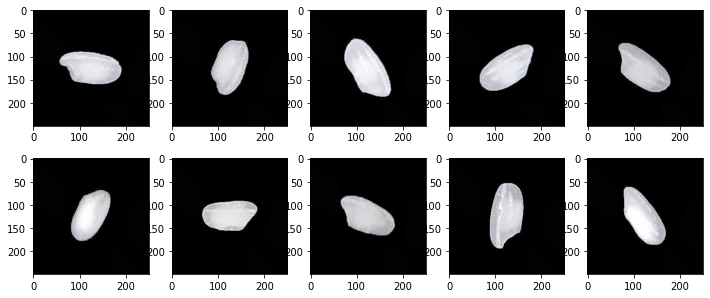


Showing 10 examples of Basmati rice:


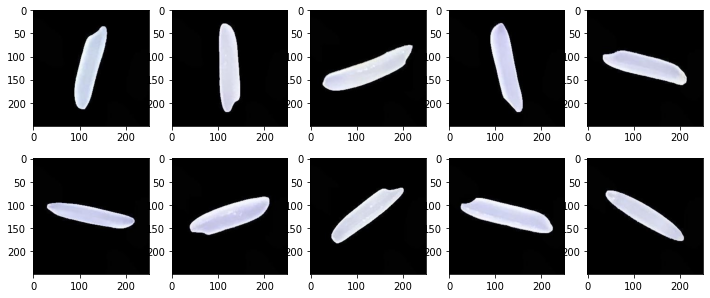


Showing 10 examples of Ipsala rice:


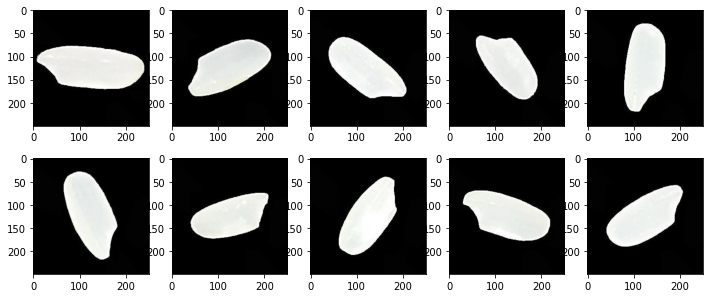


Showing 10 examples of Jasmine rice:


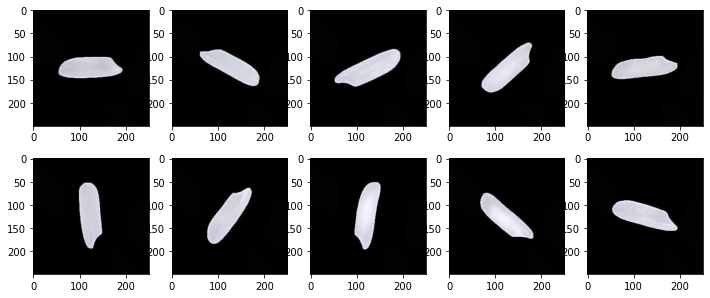


Showing 10 examples of Karacadag rice:


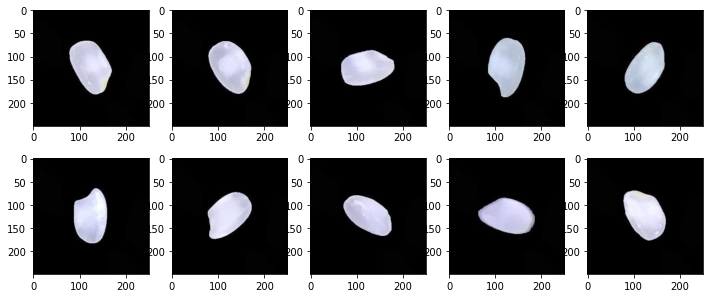

In [4]:
plt.rcParams["figure.figsize"] = (12, 5)

for category in categories:
    print(f"\nShowing 10 examples of {category} rice:")
    for i in range(1, 11):
        img_name = f"{category} ({i}).jpg"
        try:
            img = Image.open(original_dir/category/img_name)
        except:
            img = Image.open(original_dir/category/img_name.lower())
        plt.subplot(2, 5, i)
        plt.imshow(img)
    plt.show()


In [10]:
print(f"Images have size {np.array(img).shape}")

Images have size (250, 250, 3)


<a id=4></a>
<div style="padding:15px;
            color:white;
            margin:0;
            font-size:200%;
            text-align:center;
            display:fill;
            border-radius:5px;
            background-color:#5f0f40;
            overflow:hidden;
            font-weight:500">
       4. Dimensionality Reduction with PCA
</div>

[go on top](#0)
<br>[go previous chapter ↑](#3)
<br>[go next chapter ↓](#5)

In [5]:
colors = dict({
    "Arborio":"b",
    "Basmati":"g",
    "Ipsala":"r", 
    "Jasmine":"m",
    "Karacadag":"c"})

In [3]:
# Read image data in CSV
data = []
for category in categories:
    fnames = [f"{category} ({i}).jpg"
              for i in range(1, 15000)]

    for fname in fnames:
        try:
            img = Image.open(original_dir/category/fname)
        except:
            img=Image.open(original_dir/category/fname.lower())
        img = img.resize((180,180))
        data.append(np.array(img)) 

labels = []
for category in categories:
    labels += [category]*14999
print(f"There are {len(labels)} examples")

There are 74995 examples


In [6]:
# Train, validation, test split
x_train, x_test, y_train, y_test = train_test_split(data, 
                                                    labels, 
                                                    train_size=2/3, 
                                                    stratify=labels)
x_valid, x_test, y_valid, y_test = train_test_split(x_test,
                                                    y_test,
                                                    train_size=0.5,
                                                    stratify=y_test)
len(x_train), len(x_valid), len(x_test), len(y_train), len(y_valid), len(y_test)

(49996, 12499, 12500, 49996, 12499, 12500)

In [7]:
import gc
del(data)
gc.collect()

0

In [8]:
# Flatten and scale data
x_train = np.array(x_train, dtype="half").reshape((49996, -1)) / 255
x_valid = np.array(x_valid, dtype="half").reshape((12499, -1)) / 255
x_test = np.array(x_test, dtype="half").reshape((12500, -1)) / 255
x_train.shape, x_valid.shape, x_test.shape

((49996, 97200), (12499, 97200), (12500, 97200))

In [23]:
pca = PCA(n_components=2)
data_2d = pca.fit_transform(x_train[:4000])

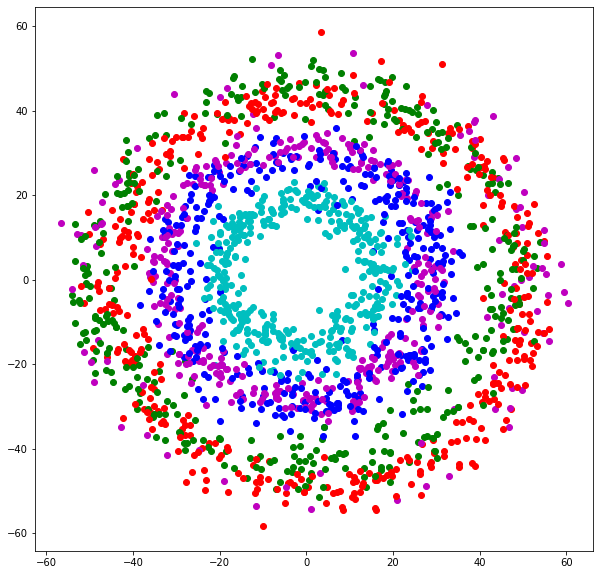

In [24]:
plt.rcParams["figure.figsize"] = (10,10)

for i in range(2000):
    plt.scatter(x=data_2d[i,0], 
                y=data_2d[i, 1], 
                c=colors[y_train[i]])
plt.show()    

In [12]:
pca = PCA(n_components=3)
data_3d = pca.fit_transform(x_train[:4000])

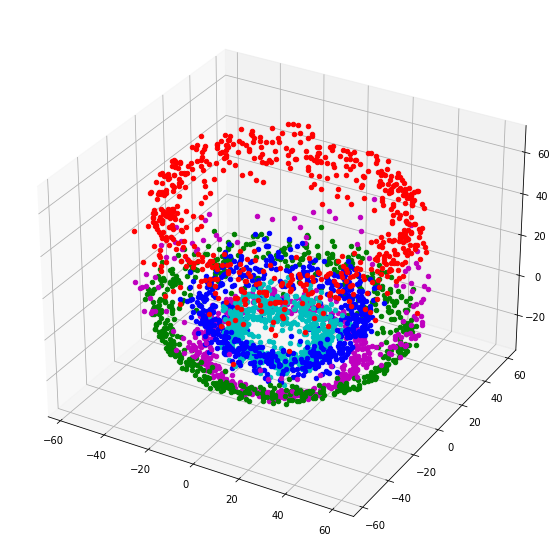

In [13]:
plt.rcParams["figure.figsize"] = (10,10)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
for i in range(3000):
    ax.scatter(xs=data_3d[i,0], 
               ys=data_3d[i, 1], 
               zs=data_3d[i, 2], 
               c=colors[y_train[i]])
plt.show()

Number of components explaining 95% variance: 293


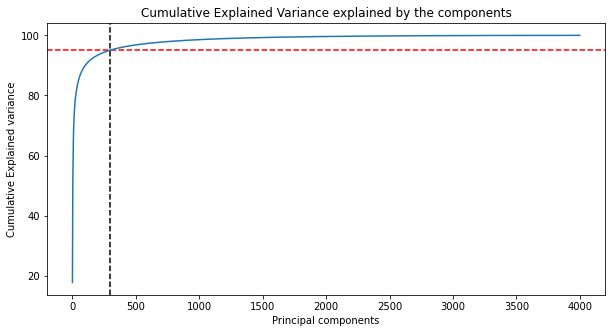

In [9]:
# Plot cumulative variance by number of components
pca = PCA()
pca = pca.fit(x_train[:4000])

var_cumu = np.cumsum(pca.explained_variance_ratio_)*100

# How many PCs explain 95% of the variance?
k = np.argmax(var_cumu>95)
print("Number of components explaining 95% variance: "+ str(k))
#print("\n")

plt.figure(figsize=[10,5])
plt.title('Cumulative Explained Variance explained by the components')
plt.ylabel('Cumulative Explained variance')
plt.xlabel('Principal components')
plt.axvline(x=k, color="k", linestyle="--")
plt.axhline(y=95, color="r", linestyle="--")
ax = plt.plot(var_cumu)

In [28]:
# Reduce dimensionality to 20 components
pca = PCA(n_components=20)
pca = pca.fit(x_train[:5000])

x_train_pca_20 = pd.DataFrame(pca.transform(x_train))
x_valid_pca_20 = pd.DataFrame(pca.transform(x_valid))
x_test_pca_20 = pd.DataFrame(pca.transform(x_test))

In [10]:
# Reduce dimensionality to 300 components (95% variance)
pca = PCA(n_components=300)
pca = pca.fit(x_train[:5000])

x_train_pca_300 = pd.DataFrame(pca.transform(x_train))
x_valid_pca_300 = pd.DataFrame(pca.transform(x_valid))
x_test_pca_300 = pd.DataFrame(pca.transform(x_test))

In [5]:
# Prepare labels
y_train = pd.DataFrame(y_train)
y_valid = pd.DataFrame(y_valid)
y_test = pd.DataFrame(y_test)

encoder = LabelEncoder()
encoder = encoder.fit(y_train)

y_train_enc = pd.DataFrame(encoder.transform(y_train))
y_valid_enc = pd.DataFrame(encoder.transform(y_valid))
y_test_enc = pd.DataFrame(encoder.transform(y_test))

y_train_ohe = pd.get_dummies(y_train)
y_valid_ohe = pd.get_dummies(y_valid)
y_test_ohe = pd.get_dummies(y_test)

C:\Users\name\anaconda3\envs\t1\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\name\anaconda3\envs\t1\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [21]:
"""
x_train_pca_20.to_csv("x_train_pca_20.csv")
x_valid_pca_20.to_csv("x_valid_pca_20.csv")
x_test_pca_20.to_csv("x_test_pca_20.csv")

x_train_pca_300.to_csv("x_train_pca_300.csv")
x_valid_pca_300.to_csv("x_valid_pca_300.csv")
x_test_pca_300.to_csv("x_test_pca_300.csv")

y_train.to_csv("y_train.csv")
y_valid.to_csv("y_valid.csv")
y_test.to_csv("y_test.csv")

"""

'\ny_train.to_csv("y_train.csv")\ny_valid.to_csv("y_valid.csv")\ny_test.to_csv("y_test.csv")\n\n'

<a id=5></a>
<div style="padding:15px;
            color:white;
            margin:0;
            font-size:200%;
            text-align:center;
            display:fill;
            border-radius:5px;
            background-color:#55828b;
            overflow:hidden;
            font-weight:500">
       5. Evaluate models on 20 PCA components
</div>



[go on top](#0)
<br>[go previous chapter ↑](#4)
<br>[go next chapter ↓](#6)

In [91]:
def model_evaluation_20(model):
    # Convert data to dataframe so that it works with all algorithms
    t0 = time()
    model = model.fit(x_train_pca_20, y_train_enc)
    print(f"Training time on CPU, on 50k examples with 20 features took {time()-t0:.6f} seconds")
    t0 = time()                      
    predictions = model.predict(x_valid_pca_20)
    print(f"Inference time on CPU, on 12500k examples with 20 features took {time()-t0:.6f} seconds")
    score = accuracy_score(predictions, y_valid_enc)
    print(f"The model has accuracy {score:.3f} on validation data")
    
    predictions = model.predict(x_test_pca_20)
    score = accuracy_score(predictions, y_test_enc)
    print(f"The model has accuracy {score:.3f} on test data")

### Logistic Regrerssion (OneVsRest)

In [92]:
model_evaluation_20(OneVsRestClassifier(LogisticRegression(random_state=1, max_iter=10000)))

Training time on CPU, on 50k examples with 20 features took 0.640855 seconds
Inference time on CPU, on 12500k examples with 20 features took 0.003986 seconds
The model has accuracy 0.930 on validation data
The model has accuracy 0.934 on test data


### SVM (OneVsOne)

I use OneVsOne strategy because SVM perfoms better on this approapch compared to OneVsRest

In [93]:
model_evaluation_20(OneVsOneClassifier(SVC()))

C:\Users\name\anaconda3\envs\t1\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training time on CPU, on 50k examples with 20 features took 2.729866 seconds
Inference time on CPU, on 12500k examples with 20 features took 6.944763 seconds
The model has accuracy 0.979 on validation data
The model has accuracy 0.977 on test data


### Decision Tree

In [94]:
model_evaluation_20(DecisionTreeClassifier(random_state=1))

Training time on CPU, on 50k examples with 20 features took 1.560778 seconds
Inference time on CPU, on 12500k examples with 20 features took 0.003987 seconds
The model has accuracy 0.954 on validation data
The model has accuracy 0.955 on test data


### Random Forest

In [95]:
model_evaluation_20(RandomForestClassifier(random_state=1))

C:\Users\name\AppData\Local\Temp\ipykernel_12448\720719591.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model = model.fit(x_train_pca_20, y_train_enc)


Training time on CPU, on 50k examples with 20 features took 14.575232 seconds
Inference time on CPU, on 12500k examples with 20 features took 0.136544 seconds
The model has accuracy 0.976 on validation data
The model has accuracy 0.973 on test data


### XGBoost Classifier

In [96]:
model_evaluation_20(XGBClassifier(random_state=1, n_jobs=10))

Training time on CPU, on 50k examples with 20 features took 9.696556 seconds
Inference time on CPU, on 12500k examples with 20 features took 0.017940 seconds
The model has accuracy 0.977 on validation data
The model has accuracy 0.978 on test data


### LightGBM Classifier

In [97]:
model_evaluation_20(LGBMClassifier())

C:\Users\name\anaconda3\envs\t1\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\name\anaconda3\envs\t1\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training time on CPU, on 50k examples with 20 features took 0.508299 seconds
Inference time on CPU, on 12500k examples with 20 features took 0.030897 seconds
The model has accuracy 0.978 on validation data
The model has accuracy 0.977 on test data


### K-nearest neighbors 

In [98]:
model_evaluation_20(KNeighborsClassifier())

Training time on CPU, on 50k examples with 20 features took 0.006976 seconds


C:\Users\name\anaconda3\envs\t1\lib\site-packages\sklearn\neighbors\_classification.py:200: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Inference time on CPU, on 12500k examples with 20 features took 0.431555 seconds
The model has accuracy 0.974 on validation data
The model has accuracy 0.973 on test data


### MLP

Training time on CPU, on 50k examples with 20 features took 34.795577 seconds
391/391 [==============================] - 0s 299us/step
Inference time on CPU, on 12500k examples with 20 features took 0.183387 seconds
The model has accuracy 0.979 on validation data
391/391 [==============================] - 0s 296us/step
The model has accuracy 0.977 on test data
loss            0.049293
accuracy        0.982879
val_loss        0.066953
val_accuracy    0.980318
Name: 39, dtype: float64


<function matplotlib.pyplot.show(close=None, block=None)>

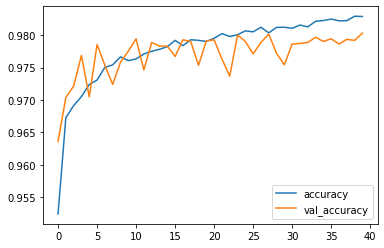

In [16]:
model = keras.Sequential([
    layers.Dense(256, activation="relu"),
    layers.Dense(160, activation="relu"),
    layers.Dense(80, activation="relu"),
    
    
    layers.Dense(5, activation="softmax")])

model.compile(optimizer="adam", 
              loss="categorical_crossentropy", 
              metrics=["accuracy"])

callbacks = [keras.callbacks.ModelCheckpoint(
    filepath="best_mlp.keras",
    save_best_only=True,
    monitor="val_loss")]       

t0 = time()
history = model.fit(x_train_pca_20, 
                    y_train_ohe,
                    epochs=40,
                    validation_data=(x_valid_pca_20, y_valid_ohe),
                    callbacks=callbacks,
                    verbose=0)
print(f"Training time on CPU, on 50k examples with 20 features took {time()-t0:.6f} seconds")

# Loat best weights
model.load_weights("best_mlp.keras")               

# Inference
t0 = time()                      
predictions = model.predict(x_valid_pca_20)
print(f"Inference time on CPU, on 12500k examples with 20 features took {time()-t0:.6f} seconds")
score = accuracy_score(np.round(predictions), y_valid_ohe)
print(f"The model has accuracy {score:.3f} on validation data")

# More inference
predictions = model.predict(x_test_pca_20)
score = accuracy_score(np.round(predictions), y_test_ohe)
print(f"The model has accuracy {score:.3f} on test data")

# Plot 
history = pd.DataFrame(history.history)
print(history.loc[history["val_accuracy"].idxmax()])
history["accuracy"].plot()
history["val_accuracy"].plot()
plt.legend(["accuracy", "val_accuracy"])
plt.show

In [15]:
predictions = model.predict(x_valid_pca_20)
print(f"Inference time on CPU, on 12500k examples with 20 features took {time()-t0:.6f} seconds")
score = accuracy_score(np.round(predictions), y_valid_ohe)
print(f"The model has accuracy {score:.3f} on validation data")

predictions = model.predict(x_test_pca_20)
score = accuracy_score(np.round(predictions), y_test_ohe)
print(f"The model has accuracy {score:.3f} on test data")



391/391 [==============================] - 0s 302us/step
Inference time on CPU, on 12500k examples with 20 features took 354.731165 seconds
The model has accuracy 0.979 on validation data
391/391 [==============================] - 0s 304us/step
The model has accuracy 0.978 on test data


<a id=6></a>    
<div style="padding:15px;
            color:white;
            margin:0;
            font-size:200%;
            text-align:center;
            display:fill;
            border-radius:5px;
            background-color:#6a994e;
            overflow:hidden;
            font-weight:500">
       6. Classical Computer Vision
</div>

[go on top](#0)
<br>[go previous chapter ↑](#5)
<br>[go next chapter ↓](#7)

In [ ]:
# Arrange images in directories
def make_subset(subset_name, start_index, end_index):
    for category in categories:
        dir = new_base_dir/subset_name/category
        os.makedirs(dir)
        fnames = [f"{category} ({i}).jpg"
                  for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir/category/fname, 
                            dst=dir/fname)
            
make_subset("train", start_index=1, end_index=10000)
make_subset("validation", start_index=10000, end_index=12500)
make_subset("test", start_index=12500, end_index=15000)

In [9]:
# Create datasets
print("\nTraining dataset:")
train_dataset = idfd(new_base_dir/"train",
                     image_size=(240, 240),
                     batch_size=64,
                     label_mode='categorical')
print("\nValidation dataset:")
validation_dataset = idfd(new_base_dir/"validation",
                          image_size=(240, 240),
                          batch_size=64,
                          label_mode='categorical')
print("\nTest dataset:")
test_dataset = idfd(new_base_dir/"test",
                    image_size=(240, 240),
                    batch_size=64,
                    label_mode='categorical')


Training dataset:
Found 49995 files belonging to 5 classes.

Validation dataset:
Found 12500 files belonging to 5 classes.

Test dataset:
Found 12500 files belonging to 5 classes.


In [10]:
# View shape of 1 batch
for data_batch, labels_batch in train_dataset:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

data batch shape: (64, 240, 240, 3)
labels batch shape: (64, 5)


# Vanilla convnet

In [17]:
# Inputs
inputs = keras.Input(shape=(240, 240, 3))

# Data augmentation
x = layers.RandomFlip("vertical")(inputs)
x = layers.RandomFlip("horizontal")(x)
x = layers.RandomRotation(0.1)(x)
x = layers.RandomZoom(0.2)(x)
x = layers.RandomContrast(0.6, 1.4)(x)

# Rescale
x = layers.Rescaling(1./255)(x)

# Convolutinal layers
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPool2D(pool_size=2)(x)
x = layers.BatchNormalization(axis=3)(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPool2D(pool_size=2)(x)
x = layers.BatchNormalization(axis=3)(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPool2D(pool_size=2)(x)
x = layers.BatchNormalization(axis=3)(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPool2D(pool_size=2)(x)
x = layers.BatchNormalization(axis=3)(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.BatchNormalization(axis=3)(x)
x = layers.Dropout(0.3)(x)

# Top layers
x = layers.Flatten()(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(32, activation="relu")(x)
x = layers.Dropout(0.3)(x)

# Output
outputs = layers.Dense(5, activation="softmax")(x)

# Create model
vanilla_convnet = keras.Model(inputs=inputs, outputs=outputs)

# Compile model
vanilla_convnet.compile(loss="categorical_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])   

In [18]:
checkpoint = keras.callbacks.ModelCheckpoint(filepath="vanilla_convnet.keras",
                                             save_best_only=True,
                                             monitor="val_accuracy",
                                             verbose=1,
                                             mode="max")      
early_stopping = keras.callbacks.EarlyStopping(monitor='val_accuracy', 
                                               mode="max", 
                                               min_delta=0.001,
                                               verbose=1, 
                                               patience=6)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', 
                                              factor=0.2,
                                              mode="max",
                                              patience=2,
                                              verbose=1,
                                              min_lr=0.0001)

callbacks = [checkpoint, early_stopping, reduce_lr]

# Train model
t0 = time()
vanilla_convnet_history = vanilla_convnet.fit(train_dataset,
                    epochs=20,
                    validation_data=validation_dataset,
                    callbacks=callbacks)
print(f"Training time on CPU, on 50k images (250, 250, 3) took {time()-t0:.1f} seconds")

Epoch 1/20
782/782 [==============================] - ETA: 0s - loss: 1.0585 - accuracy: 0.5602
Epoch 1: val_accuracy improved from -inf to 0.86440, saving model to vanilla_convnet.keras
782/782 [==============================] - 1117s 1s/step - loss: 1.0585 - accuracy: 0.5602 - val_loss: 0.4607 - val_accuracy: 0.8644 - lr: 0.0010
Epoch 2/20
782/782 [==============================] - ETA: 0s - loss: 0.4355 - accuracy: 0.8290
Epoch 2: val_accuracy improved from 0.86440 to 0.96512, saving model to vanilla_convnet.keras
782/782 [==============================] - 1103s 1s/step - loss: 0.4355 - accuracy: 0.8290 - val_loss: 0.1193 - val_accuracy: 0.9651 - lr: 0.0010
Epoch 3/20
782/782 [==============================] - ETA: 0s - loss: 0.2392 - accuracy: 0.9121
Epoch 3: val_accuracy did not improve from 0.96512
782/782 [==============================] - 1095s 1s/step - loss: 0.2392 - accuracy: 0.9121 - val_loss: 2.3286 - val_accuracy: 0.8547 - lr: 0.0010
Epoch 4/20
782/782 [==================

In [19]:
def plot_results(history):
    history = pd.DataFrame(history.history)
    print("Best results:")
    print(history.loc[history["val_accuracy"].idxmax()])
    print("\nModel performance over all epochs:")
    history["accuracy"].plot()
    history["val_accuracy"].plot()
    plt.legend(["accuracy", "val_accuracy"])
    plt.show

Best results:
loss            0.435538
accuracy        0.828963
val_loss        0.119263
val_accuracy    0.965120
lr              0.001000
Name: 1, dtype: float64

Model performance over all epochs:


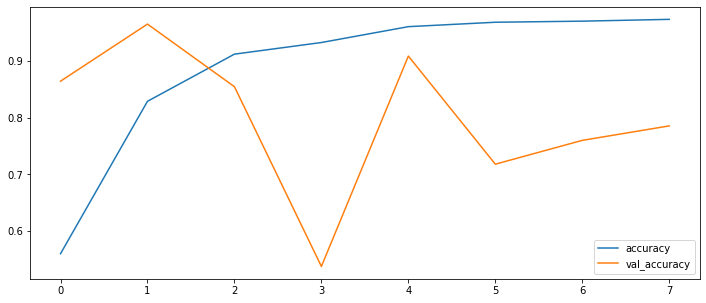

In [20]:
plot_results(vanilla_convnet_history)

In [21]:
vanilla_convnet.load_weights("vanilla_convnet.keras")

In [22]:
print("Accuracy on validation dataset:")
t0 = time()
vanilla_convnet.evaluate(validation_dataset)[1]
print(f"Inference time on CPU, on 12500k images took {time()-t0:.6f} seconds")

Accuracy on validation dataset:
196/196 [==============================] - 48s 244ms/step - loss: 0.1193 - accuracy: 0.9651
Inference time on CPU, on 12500k images took 47.921634 seconds


In [23]:
print("Accuracy on test dataset:")
t0 = time()
vanilla_convnet.evaluate(test_dataset)[1]
print(f"Inference time on GPU, on 12500k images took {time()-t0:.6f} seconds")

Accuracy on test dataset:
196/196 [==============================] - 50s 256ms/step - loss: 0.2807 - accuracy: 0.9154
Inference time on GPU, on 12500k images took 50.490064 seconds


# TRANSFER LEARNING - Mobile Net

<a id=7></a>    
<div style="padding:15px;
            color:white;
            margin:0;
            font-size:200%;
            text-align:center;
            display:fill;
            border-radius:5px;
            background-color:#bc4b51;
            overflow:hidden;
            font-weight:500">
       7. Transfer Learning - Mobile Net
</div>

[go on top](#0)
<br>[go previous chapter ↑](#6)
<!-- <br>[go next chapter ↓](#9) --!>

In [24]:
# Load mobile-net model and weights
mobile_net_base = keras.applications.MobileNetV3Small(weights="imagenet",
                                            include_top=False)
mobile_net_base.trainable = False

In [25]:
# Inputs
inputs = keras.Input(shape=(240, 240, 3))

# Data augmentation
x = layers.RandomFlip("vertical")(inputs)
x = layers.RandomFlip("horizontal")(x)
x = layers.RandomRotation(0.5)(x)
x = layers.RandomZoom(0.2)(x)
x = layers.RandomContrast(0.6, 1.4)(x)

# Preprocess input
x = keras.applications.mobilenet_v3.preprocess_input(x)

# Mobilenet base
x = mobile_net_base(x)

# Top layers
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.3)(x)

# Output layer
outputs = layers.Dense(5, activation="softmax")(x)

# Create model
mobile_net_model = keras.Model(inputs=inputs, outputs=outputs)

# Compile model
mobile_net_model.compile(loss="categorical_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

In [26]:
# Callbacks
checkpoint = keras.callbacks.ModelCheckpoint(filepath="mobile_net.keras",
                                             save_best_only=True,
                                             monitor="val_accuracy",
                                             verbose=1,
                                             mode="max")      
early_stopping = keras.callbacks.EarlyStopping(monitor='val_accuracy', 
                                               mode="max", 
                                               verbose=1,
                                               min_delta=0.001,
                                               patience=5)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', 
                                              factor=0.5,
                                              mode="max",
                                              patience=3,
                                              verbose=1,
                                              min_lr=0.00001)
callbacks = [checkpoint, early_stopping, reduce_lr]

# Fit model
mobile_net_history = mobile_net_model.fit(train_dataset,
                    epochs=30,
                    validation_data=validation_dataset,
                    callbacks=callbacks)

Epoch 1/30
782/782 [==============================] - ETA: 0s - loss: 0.2755 - accuracy: 0.9348
Epoch 1: val_accuracy improved from -inf to 0.92384, saving model to mobile_net.keras
782/782 [==============================] - 255s 323ms/step - loss: 0.2755 - accuracy: 0.9348 - val_loss: 0.4891 - val_accuracy: 0.9238 - lr: 0.0010
Epoch 2/30
782/782 [==============================] - ETA: 0s - loss: 0.1186 - accuracy: 0.9593
Epoch 2: val_accuracy did not improve from 0.92384
782/782 [==============================] - 250s 319ms/step - loss: 0.1186 - accuracy: 0.9593 - val_loss: 0.5198 - val_accuracy: 0.9067 - lr: 0.0010
Epoch 3/30
782/782 [==============================] - ETA: 0s - loss: 0.1062 - accuracy: 0.9649
Epoch 3: val_accuracy did not improve from 0.92384
782/782 [==============================] - 251s 321ms/step - loss: 0.1062 - accuracy: 0.9649 - val_loss: 0.5244 - val_accuracy: 0.9038 - lr: 0.0010
Epoch 4/30
782/782 [==============================] - ETA: 0s - loss: 0.0991 - a

Best results:
loss            0.275549
accuracy        0.934753
val_loss        0.489060
val_accuracy    0.923840
lr              0.001000
Name: 0, dtype: float64

Model performance over all epochs:


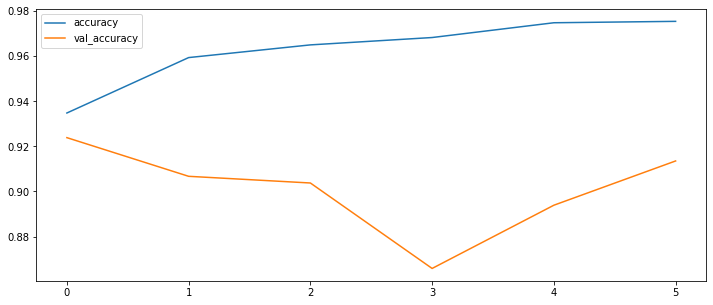

In [27]:
plot_results(mobile_net_history)

In [28]:
mobile_net_model.load_weights("mobile_net.keras")

In [29]:
print("Accuracy on validation dataset:")
t0 = time()
mobile_net_model.evaluate(validation_dataset)[1]
print(f"Inference time on CPU, on 12500k images took {time()-t0:.6f} seconds")

Accuracy on validation dataset:
196/196 [==============================] - 36s 183ms/step - loss: 0.4891 - accuracy: 0.9238
Inference time on CPU, on 12500k images took 35.952705 seconds


In [30]:
print("Accuracy on test dataset:")
t0 = time()
mobile_net_model.evaluate(test_dataset)[1]
print(f"Inference time on CPU, on 12500k images took {time()-t0:.6f} seconds")

Accuracy on test dataset:
196/196 [==============================] - 36s 184ms/step - loss: 1.3752 - accuracy: 0.8078
Inference time on CPU, on 12500k images took 36.244727 seconds
